# VARMA(p,q)
## Vector Autoregressive Moving Average
This lesson picks up where VAR(p) left off.

Recall that the system of equations for a 2-dimensional VAR(1) model is:

&nbsp;&nbsp;&nbsp;&nbsp;$y_{1,t} = c_1 + \phi_{11,1}y_{1,t-1} + \phi_{12,1}y_{2,t-1} + \varepsilon_{1,t}$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$y_{2,t} = c_2 + \phi_{21,1}y_{1,t-1} + \phi_{22,1}y_{2,t-1} + \varepsilon_{2,t}$

where the coefficient $\phi_{ii,l}$ captures the influence of the $l$th lag of variable $y_i$ on itself,<br>
the coefficient $\phi_{ij,l}$ captures the influence of the $l$th lag of variable $y_j$ on $y_i$.<br>
Most importantly, $\varepsilon_{1,t}$ and $\varepsilon_{2,t}$ are white noise processes that may be correlated.<br>

In a <strong>VARMA(p,q)</strong> model we give the error terms $\varepsilon_t$ a moving average representation of order $q$.


### Formulation
We've seen that an autoregressive moving average ARMA(p,q) model is described by the following:

&nbsp;&nbsp;&nbsp;&nbsp; $y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \dots + \phi_{p}y_{t-p} + \theta_{1}\varepsilon_{t-1} + \theta_{2}\varepsilon_{t-2} + \dots + \theta_{q}\varepsilon_{t-q} + \varepsilon_{t}$

A $K$-dimensional VARMA model of order $(p,q)$ considers each variable $y_K$ in the system.<br>

For example, the system of equations for a 2-dimensional VARMA(1,1) model is:

&nbsp;&nbsp;&nbsp;&nbsp;$y_{1,t} = c_1 + \phi_{11,1}y_{1,t-1} + \phi_{12,1}y_{2,t-1} + \theta_{11,1}\varepsilon_{1,t-1} + \theta_{12,1}\varepsilon_{2,t-1} + \varepsilon_{1,t}$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$y_{2,t} = c_2 + \phi_{21,1}y_{1,t-1} + \phi_{22,1}y_{2,t-1} + \theta_{21,1}\varepsilon_{1,t-1} + \theta_{22,1}\varepsilon_{2,t-1} + \varepsilon_{2,t}$

where the coefficient $\theta_{ii,l}$ captures the influence of the $l$th lag of error $\varepsilon_i$ on itself,<br>
the coefficient $\theta_{ij,l}$ captures the influence of the $l$th lag of error $\varepsilon_j$ on $\varepsilon_i$,<br>
and $\varepsilon_{1,t}$ and $\varepsilon_{2,t}$ are residual white noise.<br>


The general steps involved in building a VARMA model are:
* Examine the data
* Visualize the data
* Test for stationarity
* If necessary, transform the data to make it stationary
* Select the appropriate <em>p</em> and <em>q</em> orders
* Instantiate the model and fit it to a training set
* If necessary, invert the earlier transformation
* Evaluate model predictions against a known test set
* Forecast the future

<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.varmax.VARMAX.html'>
varmax.VARMAX</a></strong><font color=black>(endog[, exog, order, trend, …])</font>&nbsp;&nbsp;Vector Autoregressive Moving Average with eXogenous regressors model<br>
<strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.varmax.VARMAXResults.html'>
varmax.VARMAXResults</a></strong><font color=black>(model, params[, …])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Class to hold results from fitting an VARMAX model<br>
</tt>
   
<h3>For Further Reading:</h3>
<strong>
<a href='https://www.statsmodels.org/stable/statespace.html#vector-autoregressive-moving-average-with-exogenous-regressors-varmax'>Statsmodels Tutorial:</a></strong>&nbsp;&nbsp;<font color=black>Time Series Analysis by State Space Methods</font><br>
<strong>
<a href='https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_varmax.html'>Statsmodels Example:</a></strong>&nbsp;&nbsp;<font color=black>VARMAX models</font><br>
</div>

### Perform standard imports and load dataset
For this analysis we'll reuse our money and spending datasets. We'll look at the M2 Money Stock which is a measure of U.S. personal assets, and U.S. personal spending. Both datasets are in billions of dollars, monthly, seasonally adjusted. They span the 21 years from January 1995 to December 2015 (252 records).<br>
Sources: https://fred.stlouisfed.org/series/M2SL https://fred.stlouisfed.org/series/PCE

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tools.eval_measures import rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load datasets
df = pd.read_csv('D:/ML-Datasets/Udemy-TimeSeries/M2SLMoneyStock.csv',index_col=0, parse_dates=True)
df.index.freq = 'MS'

sp = pd.read_csv('D:/ML-Datasets/Udemy-TimeSeries/PCEPersonalSpending.csv',index_col=0, parse_dates=True)
sp.index.freq = 'MS'

### Inspect the data

In [3]:
df = df.join(sp)
df.head()

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1


In [4]:
df = df.dropna()
df.shape

(252, 2)

### Plot the source data

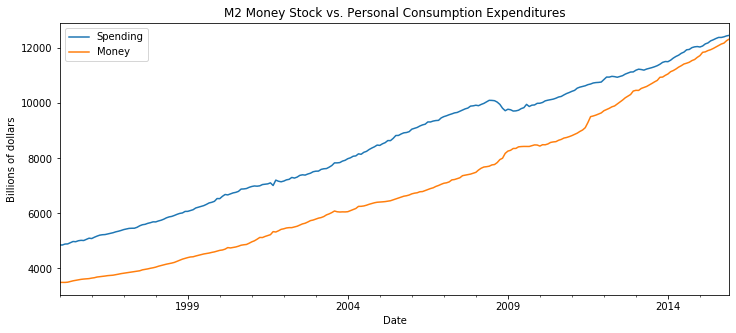

In [5]:
title = 'M2 Money Stock vs. Personal Consumption Expenditures'
ylabel='Billions of dollars'
xlabel=''

ax = df['Spending'].plot(figsize=(12,5),title=title,legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
df['Money'].plot(legend=True);

## Test for stationarity, perform any necessary transformations
In the previous section we applied the augmented Dickey-Fuller test and found that a second-order difference achieved stationarity. In this section we'll perform the <strong>auto_arima</strong> prediction to identify optimal $p$ and $q$ orders.

In [6]:
# INCLUDED HERE IF YOU CHOOSE TO USE IT
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

<div class="alert alert-info"><strong>NOTE: </strong> When performing the auto_arima function we're likely to see a <tt><font color=black>ConvergenceWarning: Maximum Likelihood optimization failed to converge.</font></tt> This is not unusual in models which have to estimate a large number of parameters. However, we can override the maximum iterations default of 50, and pass an arbitrarily large number with <tt>maxiter=1000</tt>. We'll see this come up again when we fit our model.</div>  

In [13]:
auto_arima(df['Money'],maxiter=1000)

ARIMA(maxiter=1000, method='lbfgs', order=(3, 2, 3), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)

In [14]:
auto_arima(df['Spending'],maxiter=1000)

ARIMA(maxiter=1000, method='lbfgs', order=(1, 1, 2), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)

It looks like a VARMAX(3,3) model is recommended. Note that the $d$ term (2 for Money, 1 for Spending) is about to be addressed by transforming the data to make it stationary. As before we'll apply a second order difference.

As before we'll apply a second order difference.

In [15]:
df_transformed = df.diff().diff()
df_transformed = df_transformed.dropna()
df_transformed.head()

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7


In [16]:
df_transformed.shape

(250, 2)

## Train/test/split
It is useful to define a number of observations variable for our test set. For this analysis, let's use 12 months.

In [17]:
nobs=12
train, test = df_transformed[0:-nobs], df_transformed[-nobs:]

In [18]:
print(train.shape)
print(test.shape)

(238, 2)
(12, 2)


## Fit the VARMA(3, 3) Model
This may take awhile.

In [19]:
model = VARMAX(train, order=(3, 3), trend='c')
results = model.fit(maxiter=1000, disp=False)
results.summary()

Dep. Variable:,"['Money', 'Spending']",No. Observations:,238
Model:,"VARMA(3,3)",Log Likelihood,-2270.334
,+ intercept,AIC,4598.667
Date:,"Sat, 11 Apr 2020",BIC,4699.363
Time:,12:03:43,HQIC,4639.249
Sample:,03-01-1995,,
,- 12-01-2014,,
Covariance Type:,opg,,
Ljung-Box (Q):,"44.86, 28.74",Jarque-Bera (JB):,"609.47, 131.94"
Prob(Q):,"0.28, 0.91",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"6.22, 2.74",Skew:,"1.35, -0.43"


## Predict the next 12 values
Unlike the VAR model we used in the previous section, the VARMAX <tt>.forecast()</tt> function won't require that we pass in a number of previous observations, and it will provide an extended DateTime index.

In [20]:
df_forecast = results.forecast(12)
df_forecast

,Money,Spending
2015-01-01,-13.138313,34.340744
2015-02-01,-1.385512,-5.670318
2015-03-01,1.541537,-1.863499
2015-04-01,-8.967383,1.082296
2015-05-01,6.359077,3.711186
2015-06-01,-1.846791,-4.022321
2015-07-01,-2.896923,3.140477
2015-08-01,3.848951,-0.091413
2015-09-01,-1.931018,-1.399701
2015-10-01,-0.428676,1.817383


## Invert the Transformation
Remember that the forecasted values represent second-order differences. To compare them to the original data we have to roll back each difference. To roll back a first-order difference we take the most recent value on the training side of the original series, and add it to a cumulative sum of forecasted values. When working with second-order differences we first must perform this operation on the most recent first-order difference.

Here we'll use the <tt>nobs</tt> variable we defined during the train/test/split step.

In [21]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + df_forecast['Money'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['MoneyForecast'] = df['Money'].iloc[-nobs-1] + df_forecast['Money'].cumsum()

In [22]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + df_forecast['Spending'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + df_forecast['Spending'].cumsum()

In [23]:
df_forecast

,Money,Spending,Money1d,MoneyForecast,Spending1d,SpendingForecast
2015-01-01,-13.138313,34.340744,65.461687,11656.961687,44.940744,12096.340744
2015-02-01,-1.385512,-5.670318,64.076175,11655.576175,39.270426,12090.670426
2015-03-01,1.541537,-1.863499,65.617713,11657.117713,37.406927,12088.806927
2015-04-01,-8.967383,1.082296,56.650329,11648.150329,38.489222,12089.889222
2015-05-01,6.359077,3.711186,63.009406,11654.509406,42.200408,12093.600408
2015-06-01,-1.846791,-4.022321,61.162615,11652.662615,38.178086,12089.578086
2015-07-01,-2.896923,3.140477,58.265692,11649.765692,41.318564,12092.718564
2015-08-01,3.848951,-0.091413,62.114642,11653.614642,41.227151,12092.627151
2015-09-01,-1.931018,-1.399701,60.183625,11651.683625,39.827450,12091.227450
2015-10-01,-0.428676,1.817383,59.754948,11651.254948,41.644832,12093.044832


In [24]:
pd.concat([df.iloc[-12:],df_forecast[['MoneyForecast','SpendingForecast']]],axis=1)

,Money,Spending,MoneyForecast,SpendingForecast
Date,,,,
2015-01-01,11733.2,12046.0,11656.961687,12096.340744
2015-02-01,11852.4,12082.4,11655.576175,12090.670426
2015-03-01,11868.8,12158.3,11657.117713,12088.806927
2015-04-01,11916.1,12193.8,11648.150329,12089.889222
2015-05-01,11947.6,12268.1,11654.509406,12093.600408
2015-06-01,11993.1,12308.3,11652.662615,12089.578086
2015-07-01,12045.3,12355.4,11649.765692,12092.718564
2015-08-01,12096.8,12394.0,11653.614642,12092.627151
2015-09-01,12153.8,12392.8,11651.683625,12091.227450


## Plot the results

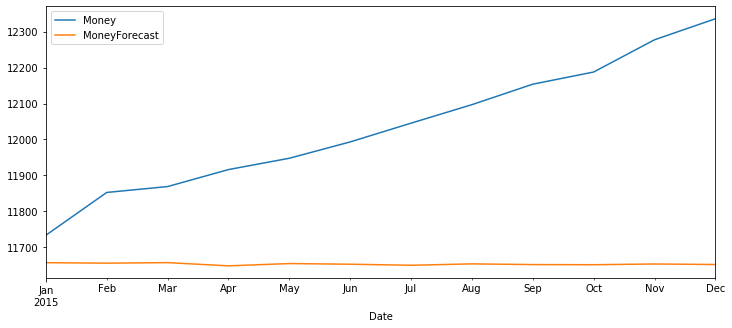

In [25]:
df['Money'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['MoneyForecast'].plot(legend=True);

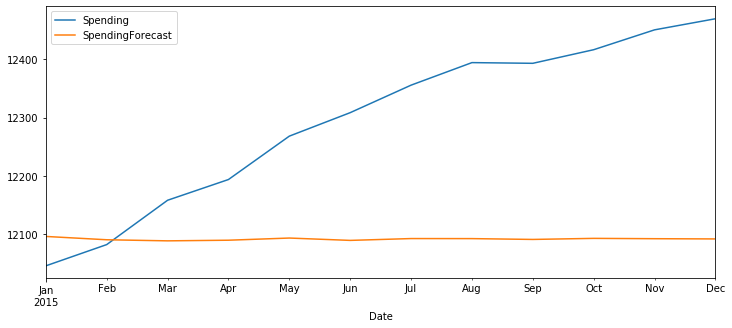

In [26]:
df['Spending'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['SpendingForecast'].plot(legend=True);

### Evaluate the model

&nbsp;&nbsp;&nbsp;&nbsp;$RMSE = \sqrt{{\frac 1 L} \sum\limits_{l=1}^L (y_{T+l} - \hat y_{T+l})^2}$<br><br>
where $T$ is the last observation period and $l$ is the lag.

In [27]:
RMSE1 = rmse(df['Money'][-nobs:], df_forecast['MoneyForecast'])
print(f'Money VAR(5) RMSE: {RMSE1:.3f}')
print()
RMSE2 = rmse(df['Spending'][-nobs:], df_forecast['SpendingForecast'])
print(f'Spending VAR(5) RMSE: {RMSE2:.3f}')

Money VAR(5) RMSE: 419.629

Spending VAR(5) RMSE: 245.236


Clearly these results are less accurate than our earlier VAR(5) model. Still, this tells us something!
## Let's compare these results to individual ARMA(3,3) models

In [29]:
from statsmodels.tsa.arima_model import ARMA,ARMAResults

### Money

In [31]:
model = ARMA(train['Money'],order=(3,3))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Money   No. Observations:                  238
Model:                     ARMA(3, 3)   Log Likelihood               -1108.971
Method:                       css-mle   S.D. of innovations             25.055
Date:                Sat, 11 Apr 2020   AIC                           2233.942
Time:                        12:16:03   BIC                           2261.720
Sample:                    03-01-1995   HQIC                          2245.137
                         - 12-01-2014                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1824      0.034      5.323      0.000       0.115       0.250
ar.L1.Money    -0.7968      0.063    -12.706      0.000      -0.920      -0.674
ar.L2.Money    -0.6313      0.070     -9.020      0.000      -0.768      -0.494
ar.L3.Money     0.3185      0.062      5.144      0.000       0.197       0.440
ma.L1.Money     0.0944        nan        nan        nan         nan         nan
ma.L2.Money    -0.0944      0.007    -13.117      0.000      -0.109      -0.080
ma.L3.Money    -1.0000        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.5644           -0.8311j            1.0046           -0.3449
AR.2           -0.5644           +0.8311j            1.0046            0.3449
AR.3            3.1107           -0.0000j            3.1107           -0.0000
MA.1           -0.5472           -0.8370j            1.0000           -0.3422
MA.2           -0.5472           +0.8370j            1.0000            0.3422
MA.3            1.0000           -0.0000j            1.0000           -0.0000
-----------------------------------------------------------------------------
"""

In [32]:
start=len(train)
end=len(train)+len(test)-1
z1 = results.predict(start=start, end=end).rename('Money')
z1 = pd.DataFrame(z1)

In [33]:
z1

,Money
2015-01-01,-19.926767
2015-02-01,-3.023876
2015-03-01,6.614438
2015-04-01,-9.323920
2015-05-01,2.675666
2015-06-01,6.245428
2015-07-01,-9.250748
2015-08-01,4.665682
2015-09-01,4.495982
2015-10-01,-9.089674


### Invert the Transformation, Evaluate the Forecast

In [34]:
# Add the most recent first difference from the training set to the forecast cumulative sum
z1['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + z1['Money'].cumsum()

# Now build the forecast values from the first difference set
z1['MoneyForecast'] = df['Money'].iloc[-nobs-1] + z1['Money1d'].cumsum()

In [35]:
z1

,Money,Money1d,MoneyForecast
2015-01-01,-19.926767,58.673233,11728.773233
2015-02-01,-3.023876,55.649357,11784.422590
2015-03-01,6.614438,62.263794,11846.686384
2015-04-01,-9.323920,52.939874,11899.626258
2015-05-01,2.675666,55.615540,11955.241798
2015-06-01,6.245428,61.860968,12017.102766
2015-07-01,-9.250748,52.610220,12069.712986
2015-08-01,4.665682,57.275902,12126.988888
2015-09-01,4.495982,61.771884,12188.760771
2015-10-01,-9.089674,52.682209,12241.442981


In [43]:
RMSE3 = rmse(df['Money'][-nobs:], z1['MoneyForecast'])

print(f'Money VARMA(3,3) RMSE: {RMSE1:.3f}')
print(f'Money  ARMA(3,3) RMSE: {RMSE3:.3f}')

Money VARMA(3,3) RMSE: 419.629
Money  ARMA(3,3) RMSE: 32.735


## Personal Spending

In [37]:
model = ARMA(train['Spending'],order=(3,3))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               Spending   No. Observations:                  238
Model:                     ARMA(3, 3)   Log Likelihood               -1181.710
Method:                       css-mle   S.D. of innovations             34.410
Date:                Sat, 11 Apr 2020   AIC                           2379.421
Time:                        12:18:50   BIC                           2407.199
Sample:                    03-01-1995   HQIC                          2390.616
                         - 12-01-2014                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0868      0.259      0.335      0.738      -0.421       0.595
ar.L1.Spending    -0.9111        nan        nan        nan         nan         nan
ar.L2.Spending    -1.0824        nan        nan        nan         nan         nan
ar.L3.Spending    -0.1018        nan        nan        nan         nan         nan
ma.L1.Spending    -0.0675      0.042     -1.607      0.108      -0.150       0.015
ma.L2.Spending     0.2921      0.034      8.638      0.000       0.226       0.358
ma.L3.Spending    -0.8758      0.042    -20.835      0.000      -0.958      -0.793
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.4046           -0.9145j            1.0000           -0.3163
AR.2           -0.4046           +0.9145j            1.0000            0.3163
AR.3           -9.8195           -0.0000j            9.8195           -0.5000
MA.1           -0.4041           -0.9147j            1.0000           -0.3162
MA.2           -0.4041           +0.9147j            1.0000            0.3162
MA.3            1.1418           -0.0000j            1.1418           -0.0000
-----------------------------------------------------------------------------
"""

In [38]:
start=len(train)
end=len(train)+len(test)-1
z2 = results.predict(start=start, end=end).rename('Spending')
z2 = pd.DataFrame(z2)
z2

,Spending
2015-01-01,30.725752
2015-02-01,-1.845417
2015-03-01,7.332245
2015-04-01,-7.543188
2015-05-01,-0.607205
2015-06-01,8.239715
2015-07-01,-5.813080
2015-08-01,-3.291795
2015-09-01,8.720568
2015-10-01,-3.521630


### Invert the Transformation, Evaluate the Forecast

In [39]:
# Add the most recent first difference from the training set to the forecast cumulative sum
z2['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + z2['Spending'].cumsum()

# Now build the forecast values from the first difference set
z2['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + z2['Spending1d'].cumsum()

In [40]:
z2

,Spending,Spending1d,SpendingForecast
2015-01-01,30.725752,41.325752,12103.325752
2015-02-01,-1.845417,39.480335,12142.806087
2015-03-01,7.332245,46.812581,12189.618668
2015-04-01,-7.543188,39.269393,12228.888060
2015-05-01,-0.607205,38.662187,12267.550248
2015-06-01,8.239715,46.901902,12314.452150
2015-07-01,-5.813080,41.088822,12355.540972
2015-08-01,-3.291795,37.797027,12393.337999
2015-09-01,8.720568,46.517595,12439.855594
2015-10-01,-3.521630,42.995964,12482.851558


In [44]:
RMSE4 = rmse(df['Spending'][-nobs:], z2['SpendingForecast'])

print(f'Spending VARMA(3,3) RMSE: {RMSE2:.3f}')
print(f'Spending  ARMA(3,3) RMSE: {RMSE4:.3f}')

Spending VARMA(3,3) RMSE: 245.236
Spending  ARMA(3,3) RMSE: 50.120


<strong>CONCLUSION:</strong> It looks like the VARMA(3,3) model did a relatively poor job compared to simpler alternatives. This tells us that there is little or no interdepence between Money Stock and Personal Consumption Expenditures, at least for the timespan we investigated. This is helpful! By fitting a model and getting poor results we know more about the data than we did before.